In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sklearn.naive_bayes import BernoulliNB

In [153]:
df=pd.read_csv('train.csv')
df.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass


# Feature Engineering and EDA 

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              2059 non-null   int64  
 1   Candidate       2059 non-null   object 
 2   Constituency ∇  2059 non-null   object 
 3   Party           2059 non-null   object 
 4   Criminal Case   2059 non-null   int64  
 5   Total Assets    2059 non-null   float64
 6   Liabilities     2059 non-null   float64
 7   state           2059 non-null   object 
 8   Education       2059 non-null   object 
 9   SC_reserv       2059 non-null   int64  
 10  ST_reserv       2059 non-null   int64  
 11  Dr              2059 non-null   int64  
 12  Adv             2059 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 209.2+ KB


In [97]:
df['Education'].value_counts()

Graduate                 531
Post Graduate            432
12th Pass                349
Graduate Professional    339
10th Pass                227
8th Pass                  78
Doctorate                 52
Others                    28
Literate                  14
5th Pass                   9
Name: Education, dtype: int64

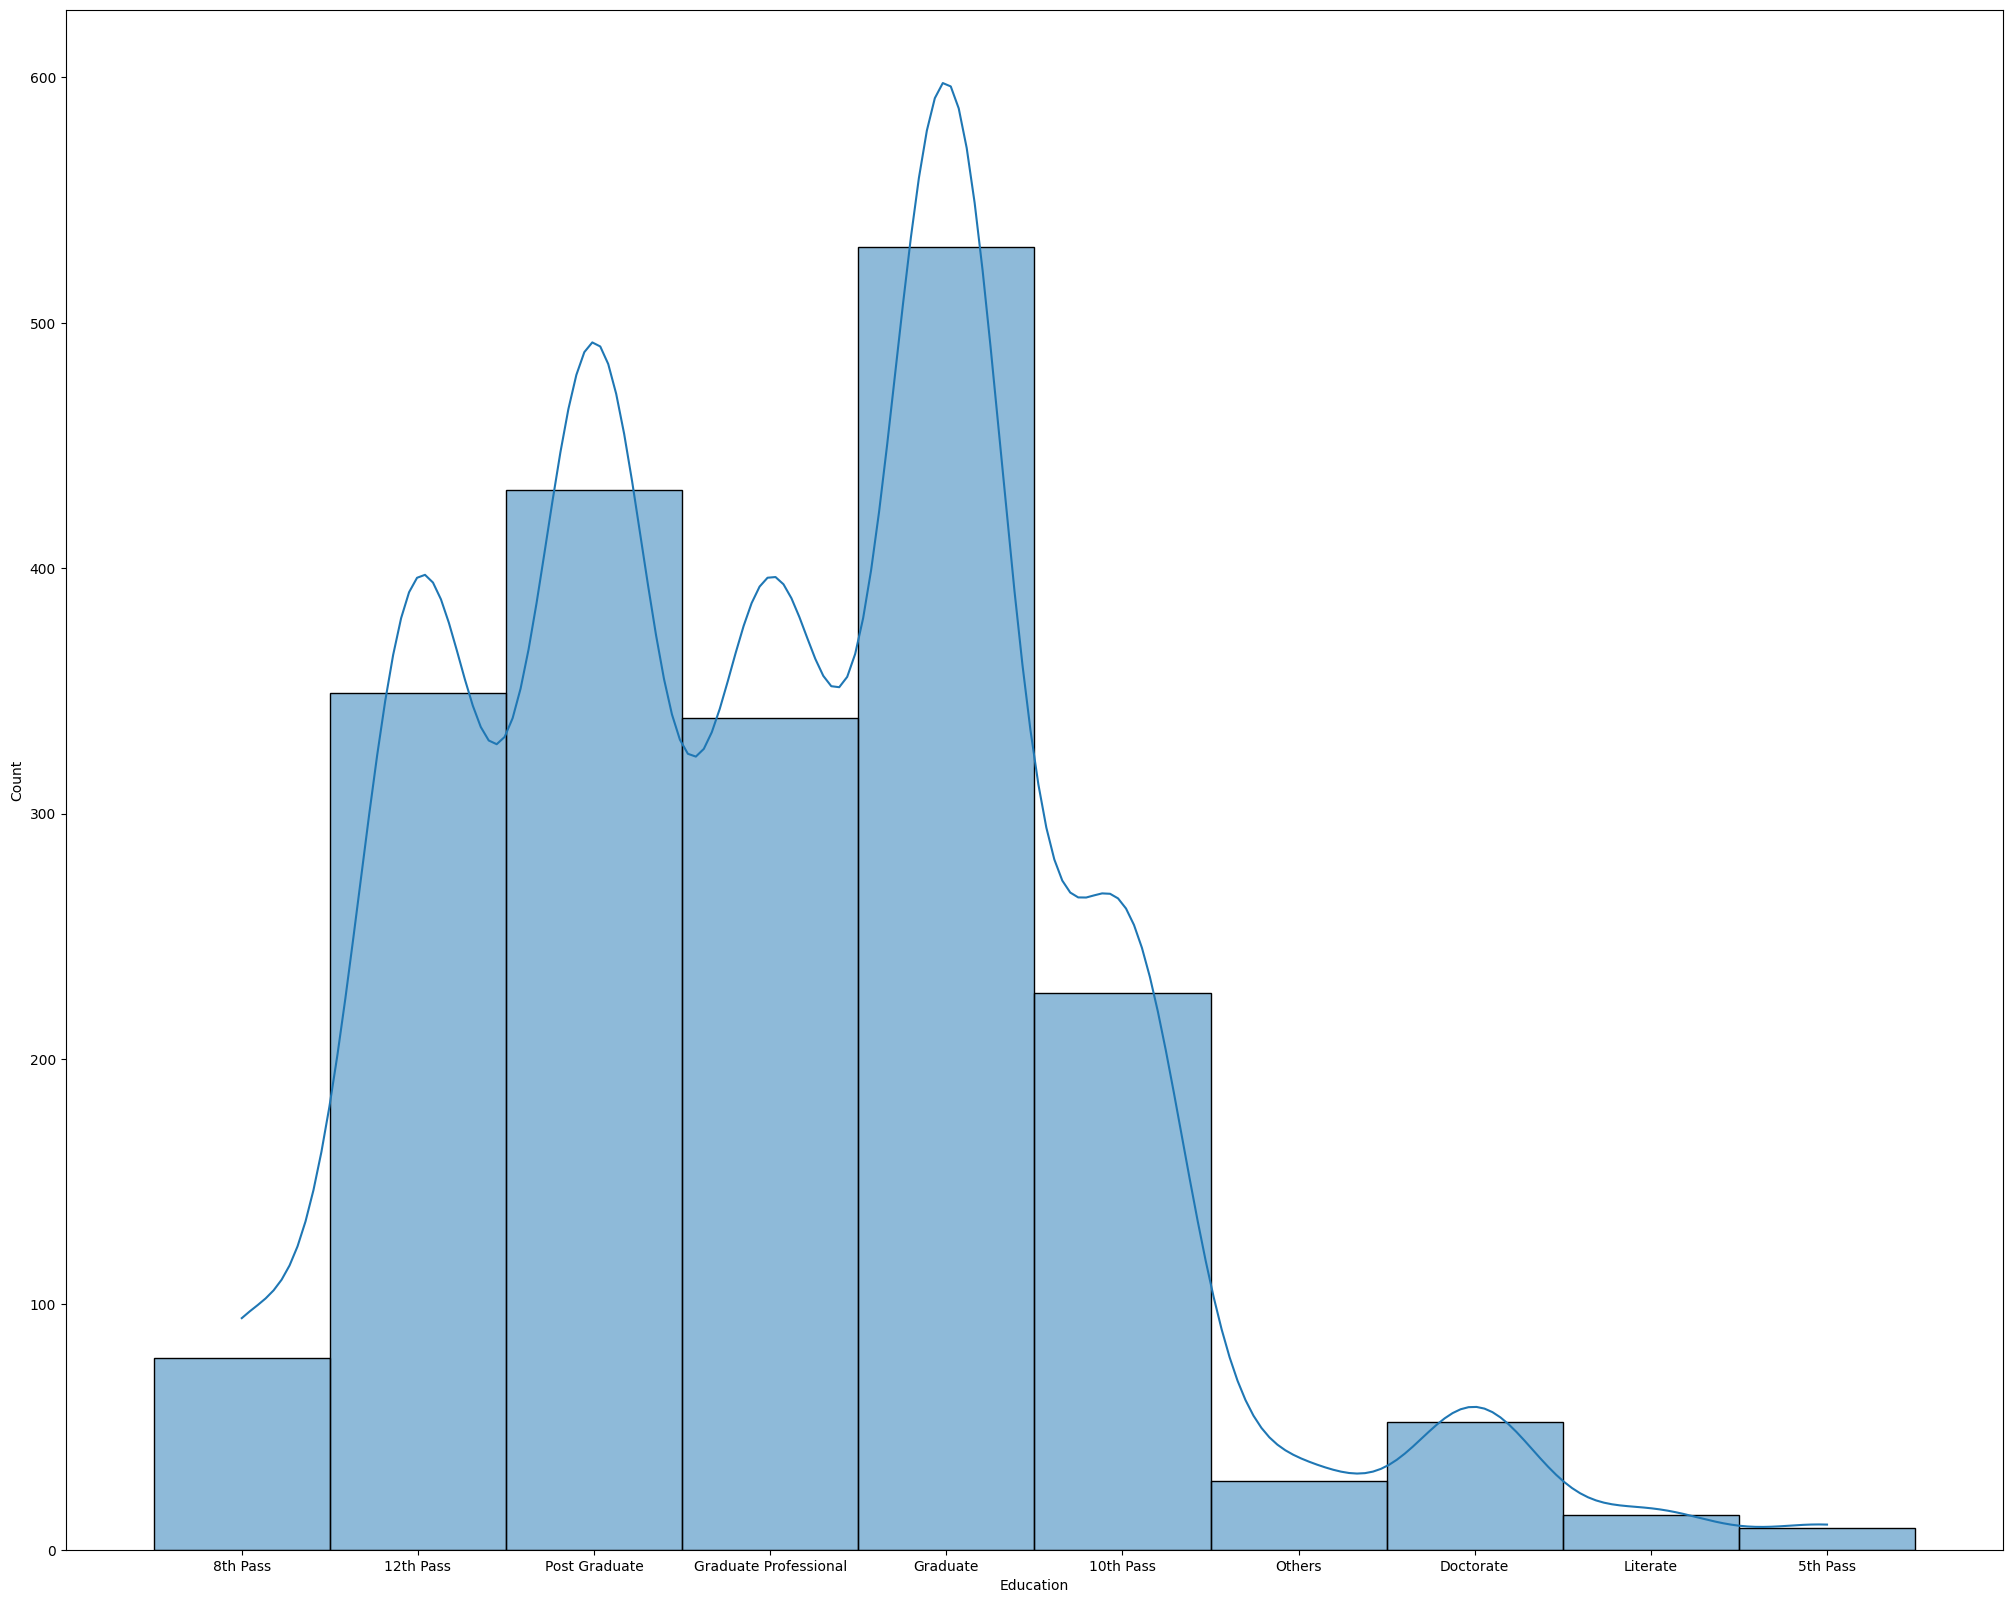

In [47]:
# Hence we see that there is large class imbalance
plt.figure(figsize=(25,20))
sns.histplot(df['Education'], kde=True)
plt.show()

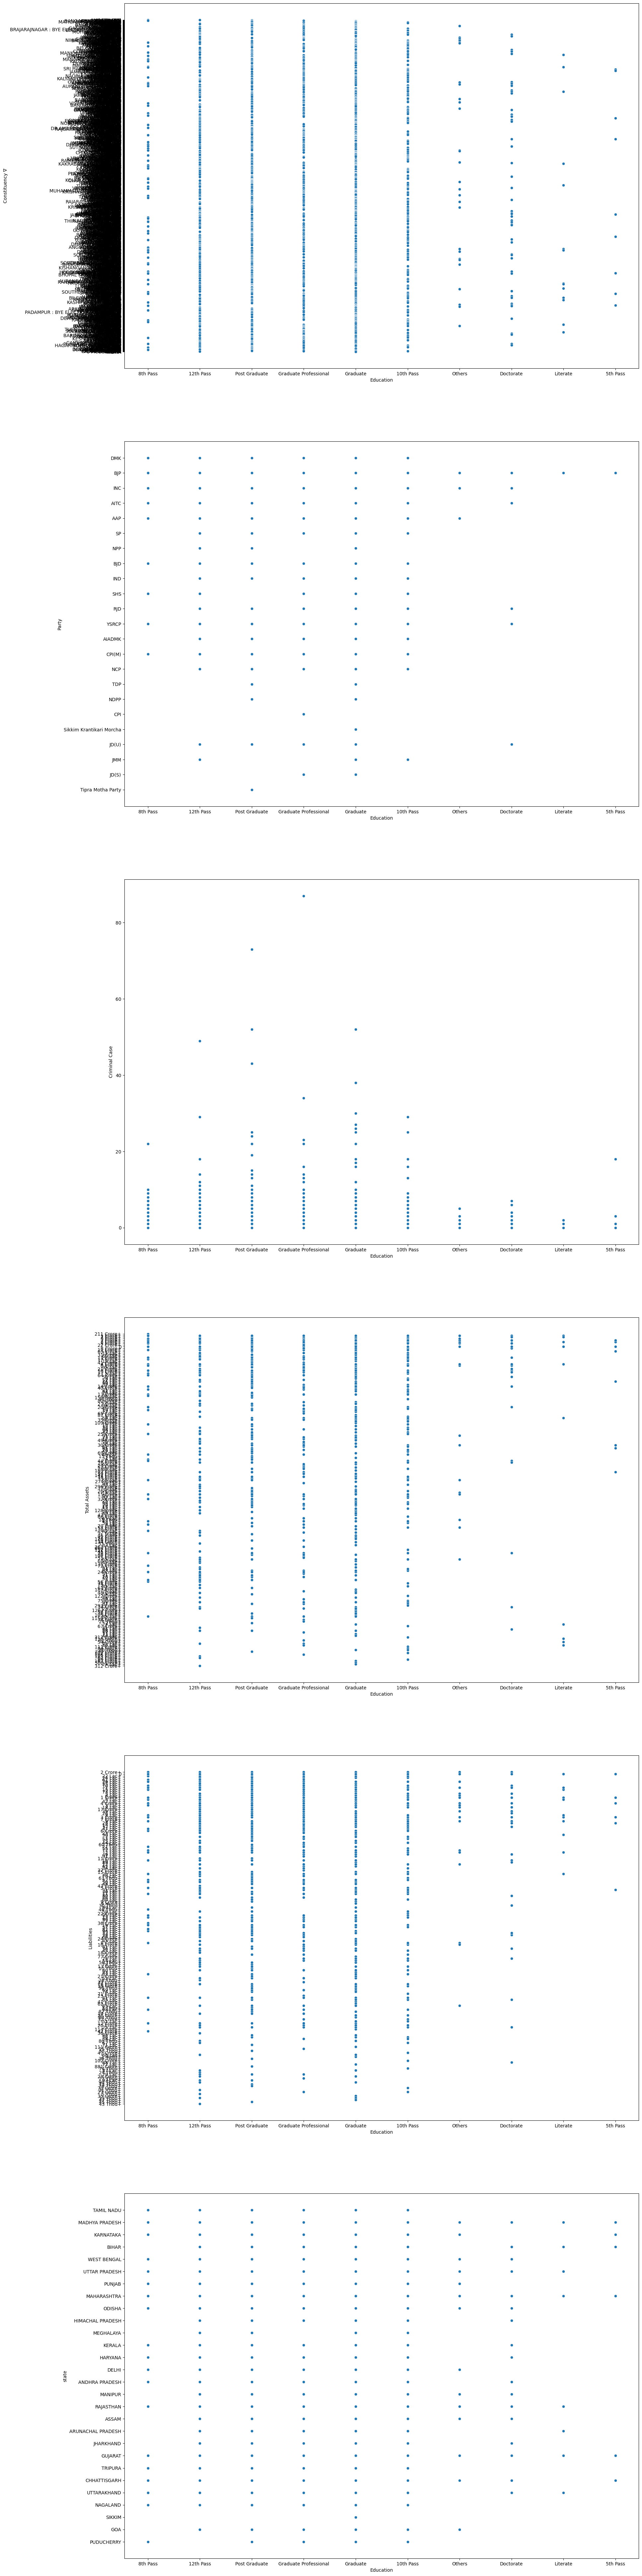

In [48]:
col=np.array(df.columns.drop(['ID','Candidate','Education']))
fig, axs = plt.subplots(6, figsize=(20, 100))
for (idx,col_name) in enumerate(col):
  sns.scatterplot(x='Education', y=col_name, data=df,ax=axs[idx])

In [49]:
# Thus we have large number of unique constituencies , thus like ID and candidate name this doesnt offer useful information
df['Constituency ∇'].value_counts()

SAGAR              3
ISLAMPUR           3
SHIVAJINAGAR       2
JALALABAD          2
SHAHPUR            2
                  ..
KUPPAM             1
PANISAGAR          1
HALIYAL            1
ALLAHABAD NORTH    1
TALIHA             1
Name: Constituency ∇, Length: 2037, dtype: int64

In [154]:
# Creating a boolean feature if the constituency is SC Reserved, which unfortunately might correlate with education level
df['SC_reserv'] = df['Constituency ∇'].str.contains("(SC)").astype(int)

/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_40960/514494673.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['SC_reserv'] = df['Constituency ∇'].str.contains("(SC)").astype(int)


In [155]:
# Creating a boolean feature if the constituency is SC Reserved, which unfortunately might correlate with education level
df['ST_reserv'] = df['Constituency ∇'].str.contains("(ST)").astype(int)

/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_40960/841282182.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['ST_reserv'] = df['Constituency ∇'].str.contains("(ST)").astype(int)


In [156]:
# From the Candidate Name we can use the "Dr." to generate a new boolean variable which has strong 
# correlation with Education Level
df['Dr'] = df['Candidate'].str.contains("Dr").astype(int)

In [157]:
# From the Candidate Name we can use the "Adv." to generate a new boolean variable 
# which has strong correlation with Education Level
df['Adv '] = df['Candidate'].str.contains("Adv.").astype(int)

In [158]:
df

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,SC_reserv,ST_reserv,Dr,Adv
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass,0,0,0,0
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass,1,0,0,0
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate,0,0,1,0
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate,0,0,0,0
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,V. Sasi,CHIRAYINKEEZHU,CPI,1,61 Lac+,10 Lac+,KERALA,Graduate Professional,0,0,0,0
2055,2055,Pushkar Lal Dangi,MAVLI,INC,0,2 Crore+,8 Lac+,RAJASTHAN,10th Pass,0,0,0,0
2056,2056,Dr. Manju Shiwach,MODI NAGAR,BJP,0,13 Crore+,85 Lac+,UTTAR PRADESH,Graduate,0,0,1,0
2057,2057,Mansing Fattesingrao Naik,SHIRALA,NCP,1,25 Crore+,94 Lac+,MAHARASHTRA,12th Pass,0,0,0,0


In [159]:
#Changing english values in Total Assets and Liabilities to numbers
df['Total Assets'] = df['Total Assets'].astype(str)
df['Liabilities'] = df['Liabilities'].astype(str)
df['Total Assets'] = df['Total Assets'].str.replace(r' Crore\+', "e7",regex=True)
df['Total Assets'] = df['Total Assets'].str.replace(r' Lac\+', 'e5',regex=True)
df['Total Assets'] = df['Total Assets'].str.replace(r' Thou\+', 'e3',regex=True)
df['Liabilities'] = df['Liabilities'].str.replace(r' Crore\+', 'e7',regex=True)
df['Liabilities'] = df['Liabilities'].str.replace(r' Lac\+', 'e5',regex=True)
df['Liabilities'] = df['Liabilities'].str.replace(r' Thou\+', 'e3',regex=True)
df['Liabilities'] = df['Liabilities'].str.replace(r' Hund\+', 'e2',regex=True)
df['Total Assets'] = pd.to_numeric(df['Total Assets'], errors='coerce')
df['Liabilities'] = pd.to_numeric(df['Liabilities'], errors='coerce')

In [56]:
df1=df.copy()
# Using Min Max Scaler to deal with deal with very large values of the Assets and Liabilities Column
scaler = MinMaxScaler()

# Fitting and transform the 'Total Assets' column
df1['Total Assets'] = scaler.fit_transform(df[['Total Assets']].values)

# Fitting and transform the 'Liabilities' column
df1['Liabilities'] = scaler.fit_transform(df[['Liabilities']].values)


In [57]:
df1

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,SC_reserv,ST_reserv,Dr,Adv
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,0.166535,0.002270,TAMIL NADU,8th Pass,0,0,0,0
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,0.000789,0.000000,MADHYA PRADESH,12th Pass,1,0,0,0
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,0.005525,0.000250,KARNATAKA,Post Graduate,0,0,1,0
3,3,Kundan Kumar,BEGUSARAI,BJP,0,0.007103,0.000272,BIHAR,Post Graduate,0,0,0,0
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,0.001579,0.000692,WEST BENGAL,8th Pass,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,V. Sasi,CHIRAYINKEEZHU,CPI,1,0.000481,0.000114,KERALA,Graduate Professional,0,0,0,0
2055,2055,Pushkar Lal Dangi,MAVLI,INC,0,0.001579,0.000091,RAJASTHAN,10th Pass,0,0,0,0
2056,2056,Dr. Manju Shiwach,MODI NAGAR,BJP,0,0.010260,0.000965,UTTAR PRADESH,Graduate,0,0,1,0
2057,2057,Mansing Fattesingrao Naik,SHIRALA,NCP,1,0.019732,0.001067,MAHARASHTRA,12th Pass,0,0,0,0


In [58]:
df1.isnull().values.any()

False

In [59]:
# Prediction Data
df_pred=pd.read_csv('test.csv')
df_pred

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state
0,0,Geeta Bharat Jain,MEERA BHAYANDAR,IND,2,70 Crore+,11 Crore+,MAHARASHTRA
1,1,Becharam Manna,SINGUR,AITC,1,2 Crore+,13 Lac+,WEST BENGAL
2,2,Sunil Vijay Tingre,VADGAON SHERI,NCP,3,49 Crore+,1 Crore+,MAHARASHTRA
3,3,Asit Mazumder (Tapan),CHUNCHURA,AITC,1,2 Crore+,0,WEST BENGAL
4,4,Hriday Narayan Singh Patel,SAGRI,SP,0,16 Crore+,2 Crore+,UTTAR PRADESH
...,...,...,...,...,...,...,...,...
1369,1369,Niladri Sekhar Dana,BANKURA,BJP,0,1 Crore+,0,WEST BENGAL
1370,1370,Mukesh Kumar Pal,PALLAHARA,BJD,1,0,13 Lac+,ODISHA
1371,1371,Vijay Shanker Dubey,MAHARAJGANJ,INC,1,5 Crore+,0,BIHAR
1372,1372,Satpal Singh Satti,UNA,BJP,1,2 Crore+,5 Lac+,HIMACHAL PRADESH


In [60]:
# Repaeting similar feature engineering
df_pred['SC_reserv'] = df_pred['Constituency ∇'].str.contains("(SC)").astype(int)
df_pred['ST_reserv'] = df['Constituency ∇'].str.contains("(ST)").astype(int)
df_pred['Dr'] = df_pred['Candidate'].str.contains("Dr").astype(int)
df_pred['Adv '] = df_pred['Candidate'].str.contains("Adv.").astype(int)

/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_40960/2650946528.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_pred['SC_reserv'] = df_pred['Constituency ∇'].str.contains("(SC)").astype(int)
/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_40960/2650946528.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_pred['ST_reserv'] = df['Constituency ∇'].str.contains("(ST)").astype(int)


In [61]:
df_pred['Total Assets'] = df_pred['Total Assets'].astype(str)
df_pred['Liabilities'] = df_pred['Liabilities'].astype(str)
df_pred['Total Assets'] = df_pred['Total Assets'].str.replace(r' Crore\+', "e7",regex=True)
df_pred['Total Assets'] = df_pred['Total Assets'].str.replace(r' Lac\+', 'e5',regex=True)
df_pred['Total Assets'] = df_pred['Total Assets'].str.replace(r' Thou\+', 'e3',regex=True)
df_pred['Liabilities'] = df_pred['Liabilities'].str.replace(r' Crore\+', 'e7',regex=True)
df_pred['Liabilities'] = df_pred['Liabilities'].str.replace(r' Lac\+', 'e5',regex=True)
df_pred['Liabilities'] = df_pred['Liabilities'].str.replace(r' Thou\+', 'e3',regex=True)
df_pred['Liabilities'] = df_pred['Liabilities'].str.replace(r' Hund\+', 'e2',regex=True)
df_pred['Total Assets'] = pd.to_numeric(df_pred['Total Assets'], errors='coerce')
df_pred['Liabilities'] = pd.to_numeric(df_pred['Liabilities'], errors='coerce')

In [62]:
df_pred1=df_pred.copy()
# Fitting and transform the 'Total Assets' column
df_pred1['Total Assets'] = scaler.fit_transform(df_pred[['Total Assets']].values)

# Fitting and transform the 'Liabilities' column
df_pred1['Liabilities'] = scaler.fit_transform(df_pred[['Liabilities']].values)

In [63]:
df_pred

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,SC_reserv,ST_reserv,Dr,Adv
0,0,Geeta Bharat Jain,MEERA BHAYANDAR,IND,2,0.049540,0.038869,MAHARASHTRA,0,0,0,0
1,1,Becharam Manna,SINGUR,AITC,1,0.001415,0.000459,WEST BENGAL,0,0,0,0
2,2,Sunil Vijay Tingre,VADGAON SHERI,NCP,3,0.034678,0.003534,MAHARASHTRA,0,0,0,0
3,3,Asit Mazumder (Tapan),CHUNCHURA,AITC,1,0.001415,0.000000,WEST BENGAL,0,0,0,0
4,4,Hriday Narayan Singh Patel,SAGRI,SP,0,0.011323,0.007067,UTTAR PRADESH,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1369,1369,Niladri Sekhar Dana,BANKURA,BJP,0,0.000708,0.000000,WEST BENGAL,0,0,0,0
1370,1370,Mukesh Kumar Pal,PALLAHARA,BJD,1,0.000000,0.000459,ODISHA,0,1,0,0
1371,1371,Vijay Shanker Dubey,MAHARAJGANJ,INC,1,0.003539,0.000000,BIHAR,0,0,0,0
1372,1372,Satpal Singh Satti,UNA,BJP,1,0.001415,0.000177,HIMACHAL PRADESH,0,0,0,0


#### One Hot Encoding

In [64]:
df1=pd.get_dummies(df1, columns=['Party', 'state'],dtype=int)
df1=df1.drop(columns=['Candidate','Constituency ∇'])
df1

,ID,Criminal Case,Total Assets,Liabilities,Education,SC_reserv,ST_reserv,Dr,Adv,Party_AAP,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,0,4,0.166535,0.002270,8th Pass,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0.000789,0.000000,12th Pass,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0.005525,0.000250,Post Graduate,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0.007103,0.000272,Post Graduate,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2,0.001579,0.000692,8th Pass,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,1,0.000481,0.000114,Graduate Professional,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2055,2055,0,0.001579,0.000091,10th Pass,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2056,2056,0,0.010260,0.000965,Graduate,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2057,2057,1,0.019732,0.001067,12th Pass,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df_pred1=df_pred.copy()
df_pred1=pd.get_dummies(df_pred1, columns=['Party', 'state'])
df_pred1

,ID,Candidate,Constituency ∇,Criminal Case,Total Assets,Liabilities,SC_reserv,ST_reserv,Dr,Adv,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,0,Geeta Bharat Jain,MEERA BHAYANDAR,2,0.049540,0.038869,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Becharam Manna,SINGUR,1,0.001415,0.000459,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,Sunil Vijay Tingre,VADGAON SHERI,3,0.034678,0.003534,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Asit Mazumder (Tapan),CHUNCHURA,1,0.001415,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,Hriday Narayan Singh Patel,SAGRI,0,0.011323,0.007067,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,1369,Niladri Sekhar Dana,BANKURA,0,0.000708,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1370,1370,Mukesh Kumar Pal,PALLAHARA,1,0.000000,0.000459,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1371,1371,Vijay Shanker Dubey,MAHARAJGANJ,1,0.003539,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1372,1372,Satpal Singh Satti,UNA,1,0.001415,0.000177,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Generating Synthetic Data Using CTGAN

In [66]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df1)

In [67]:
#  Changing the wrong sdata type to create the correct metadata
states=['state_ANDHRA PRADESH',
       'state_ARUNACHAL PRADESH', 'state_ASSAM', 'state_BIHAR',
       'state_CHHATTISGARH', 'state_DELHI', 'state_GOA', 'state_GUJARAT',
       'state_HARYANA', 'state_HIMACHAL PRADESH', 'state_JHARKHAND',
       'state_KARNATAKA', 'state_KERALA', 'state_MADHYA PRADESH',
       'state_MAHARASHTRA', 'state_MANIPUR', 'state_MEGHALAYA',
       'state_NAGALAND', 'state_ODISHA', 'state_PUDUCHERRY', 'state_PUNJAB',
       'state_RAJASTHAN', 'state_SIKKIM', 'state_TAMIL NADU', 'state_TRIPURA',
       'state_UTTAR PRADESH', 'state_UTTARAKHAND', 'state_WEST BENGAL']
for col_name in states:

    metadata.update_column(
        column_name=col_name,
        sdtype='categorical',
        )

In [68]:
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "ID": {
            "sdtype": "id"
        },
        "Criminal Case": {
            "sdtype": "numerical"
        },
        "Total Assets": {
            "sdtype": "numerical"
        },
        "Liabilities": {
            "sdtype": "numerical"
        },
        "Education": {
            "sdtype": "categorical"
        },
        "SC_reserv": {
            "sdtype": "categorical"
        },
        "ST_reserv": {
            "sdtype": "categorical"
        },
        "Dr": {
            "sdtype": "categorical"
        },
        "Adv ": {
            "sdtype": "categorical"
        },
        "Party_AAP": {
            "sdtype": "categorical"
        },
        "Party_AIADMK": {
            "sdtype": "categorical"
        },
        "Party_AITC": {
            "sdtype": "categorical"
        },
        "Party_BJD": {
            "sdtype": "categorical"
        },
        "Party_BJP": {
            "sdtype":

In [69]:
synthesizer = CTGANSynthesizer(metadata,cuda=True)
synthesizer.fit(df1)

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sdv/single_table/base.py:80: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Inte

In [72]:
# Generating around 25 % more data
synthetic_data = synthesizer.sample(num_rows=500)

In [73]:
synthetic_data

,ID,Criminal Case,Total Assets,Liabilities,Education,SC_reserv,ST_reserv,Dr,Adv,Party_AAP,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,500,0,0.000000,0.000893,Post Graduate,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,501,0,0.000000,0.000000,Post Graduate,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,502,0,0.000000,0.000000,Post Graduate,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,503,5,0.000258,0.000325,Graduate,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,504,0,0.015527,0.000000,Graduate Professional,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,995,0,0.000000,0.000127,Graduate,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
496,996,0,0.000000,0.003218,10th Pass,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
497,997,0,0.000000,0.000000,12th Pass,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,998,0,0.000000,0.000544,Graduate,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Combing the orginal and the synthesised data
df_comb=pd.concat([df1,synthetic_data])

In [75]:
df_comb

,ID,Criminal Case,Total Assets,Liabilities,Education,SC_reserv,ST_reserv,Dr,Adv,Party_AAP,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,0,4,0.166535,0.002270,8th Pass,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0.000789,0.000000,12th Pass,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0.005525,0.000250,Post Graduate,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0.007103,0.000272,Post Graduate,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2,0.001579,0.000692,8th Pass,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,995,0,0.000000,0.000127,Graduate,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
496,996,0,0.000000,0.003218,10th Pass,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
497,997,0,0.000000,0.000000,12th Pass,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,998,0,0.000000,0.000544,Graduate,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


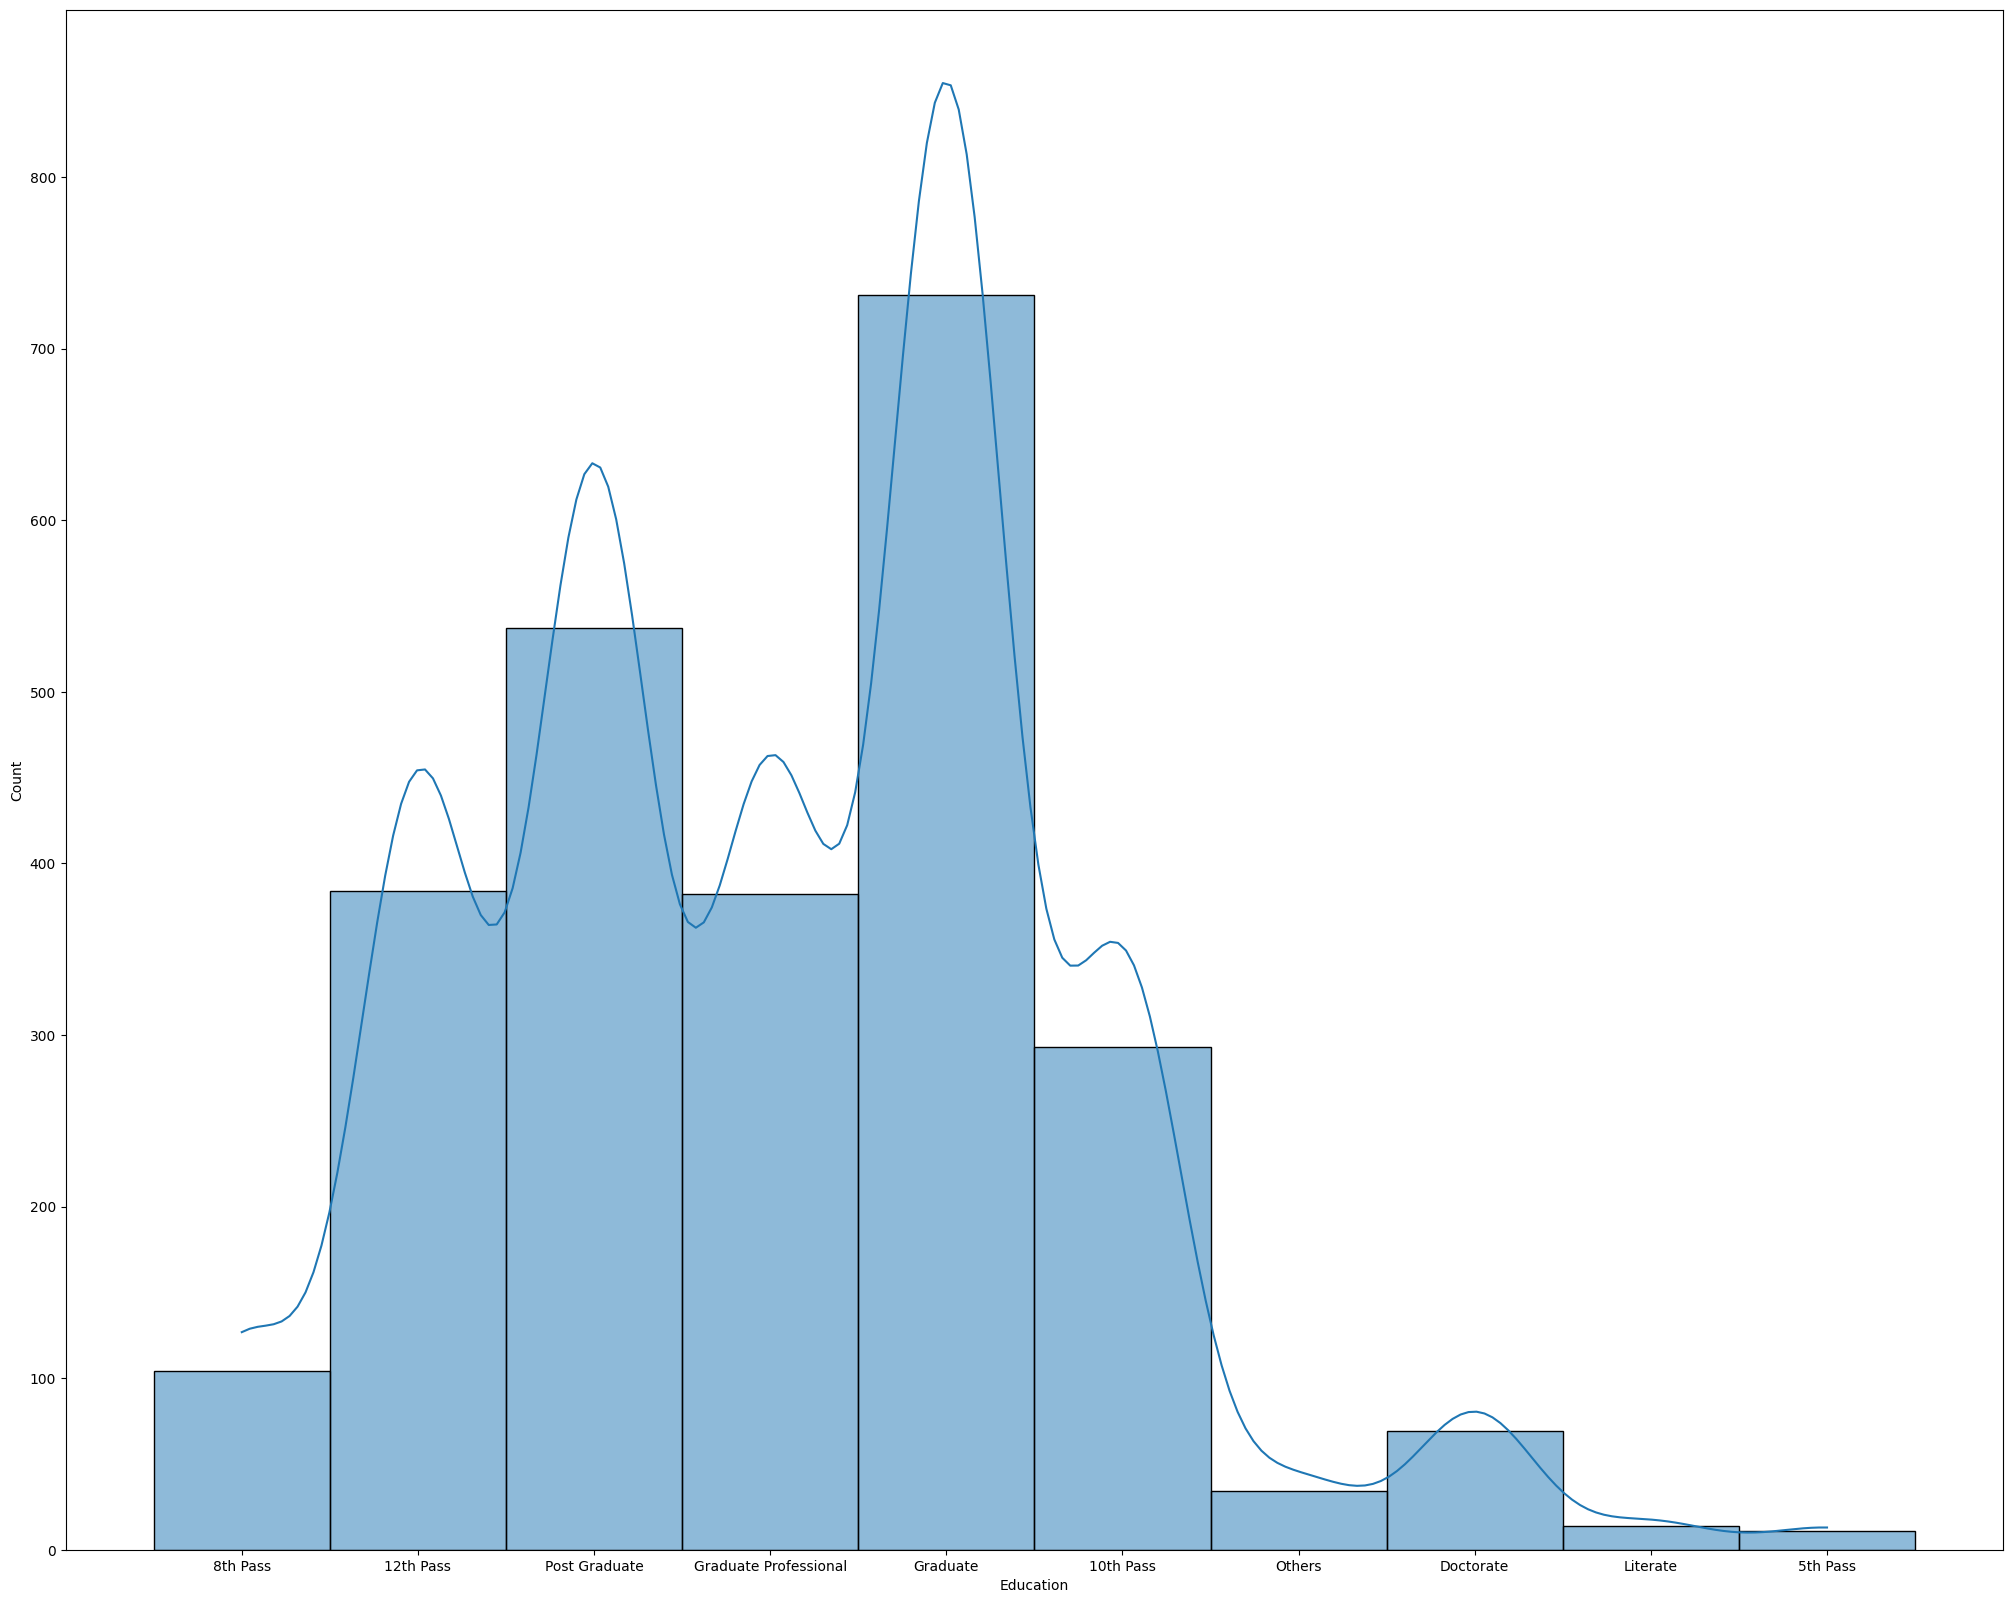

In [98]:
# Hence we see that there is large class imbalance
plt.figure(figsize=(25,20))
sns.histplot(df_comb['Education'], kde=True)
plt.show()

In [84]:
X=np.array(df_comb.drop(columns=['Education','ID']))
y=np.array(df_comb['Education'])

In [85]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
X_pred=np.array(df_pred1.drop(columns=['ID','Candidate','Constituency ∇']))

# Naive Bayes ML Model

In [87]:

# Instantiating the Bernoulli Naive Bayes model
model = BernoulliNB()

# Train the model on the training data
model.fit(X_train, y_train)


BernoulliNB()

In [93]:
# Make predictions on the test data
y_pred_bnb = model.predict(X_test)
f1_score(y_test, y_pred_bnb,average='weighted')

0.22330491499122895

In [94]:
#Training Set f1 score
y_pred_tr = model.predict(X_train)
f1_score(y_train, y_pred_tr,average='weighted')

0.2850331904810809

In [95]:
y_pred_bf=model.predict(X_pred)
pred_bf = pd.DataFrame(y_pred_bf, columns=['Education'])
pred_bf.index.names = ['ID']
pred_bf

,Education
ID,
0,12th Pass
1,12th Pass
2,Graduate
3,Graduate
4,Post Graduate
...,...
1369,Graduate
1370,Graduate
1371,Graduate


In [ ]:
pred_bf.to_csv('prednv.csv')

In [99]:
pred_bf['Education'].value_counts()

Graduate                 604
Post Graduate            386
12th Pass                170
Graduate Professional    162
10th Pass                 40
8th Pass                   6
Doctorate                  6
Name: Education, dtype: int64

In [104]:
df

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,SC_reserv,ST_reserv,Dr,Adv
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,0.166535,0.002270,TAMIL NADU,8th Pass,0,0,0,0
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,0.000789,0.000000,MADHYA PRADESH,12th Pass,1,0,0,0
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,0.005525,0.000250,KARNATAKA,Post Graduate,0,0,1,0
3,3,Kundan Kumar,BEGUSARAI,BJP,0,0.007103,0.000272,BIHAR,Post Graduate,0,0,0,0
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,0.001579,0.000692,WEST BENGAL,8th Pass,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,V. Sasi,CHIRAYINKEEZHU,CPI,1,0.000481,0.000114,KERALA,Graduate Professional,0,0,0,0
2055,2055,Pushkar Lal Dangi,MAVLI,INC,0,0.001579,0.000091,RAJASTHAN,10th Pass,0,0,0,0
2056,2056,Dr. Manju Shiwach,MODI NAGAR,BJP,0,0.010260,0.000965,UTTAR PRADESH,Graduate,0,0,1,0
2057,2057,Mansing Fattesingrao Naik,SHIRALA,NCP,1,0.019732,0.001067,MAHARASHTRA,12th Pass,0,0,0,0


### Plots

In [144]:
df['Criminal Case'].describe()

count    2059.000000
mean        1.777562
std         4.762183
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        87.000000
Name: Criminal Case, dtype: float64

In [149]:
xp=np.array(df['Party'].unique())
yp=[]
for party in xp:
    yp.append(df[(df['Party'] == party) & (df['Criminal Case'] > 2)].shape[0])
yp=np.divide(yp,np.sum(yp))
yp=np.multiply(yp,100)

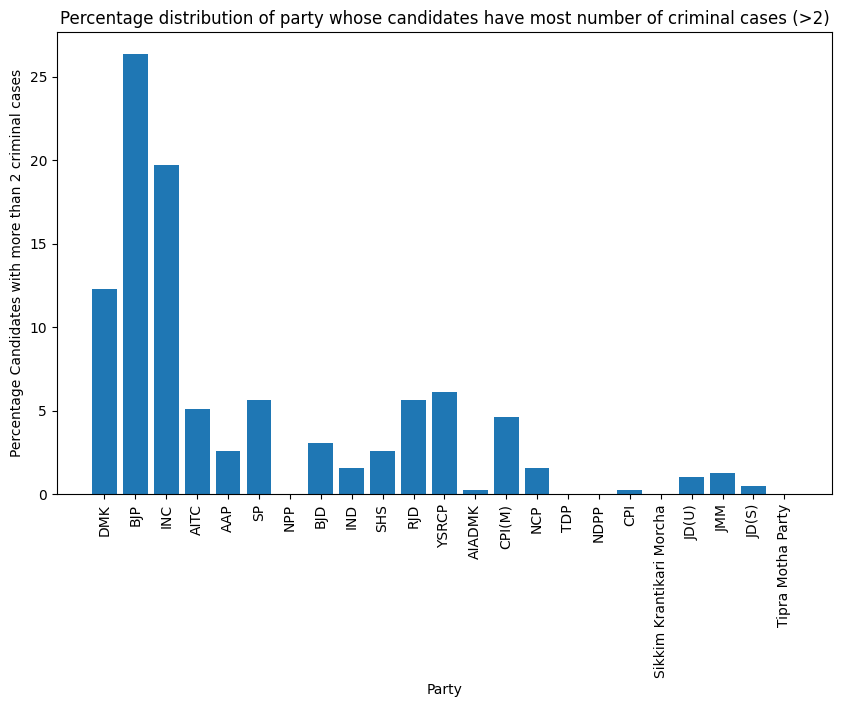

In [151]:
plt.figure(figsize=(10, 6))
plt.bar(xp, yp)
plt.xlabel('Party')
plt.ylabel('Percentage Candidates with more than 2 criminal cases')
plt.title('Percentage distribution of party whose candidates have most number of criminal cases (>2)')
plt.xticks(rotation=90)
plt.show()


In [167]:
df['net_worth']=df['Total Assets'].values-df['Liabilities'].values

In [170]:
df['net_worth'].describe()

count    2.059000e+03
mean     9.400845e+07
std      4.046811e+08
min     -7.100000e+08
25%      6.800000e+06
50%      2.000000e+07
75%      7.000000e+07
max      1.262000e+10
Name: net_worth, dtype: float64

In [174]:
xp2=np.array(df['Party'].unique())
yp2=[]
for party in xp2:
    yp2.append(df[(df['Party'] == party) & (df['net_worth'] > 7e7)].shape[0])
yp2=np.divide(yp2,np.sum(yp2))
yp2=np.multiply(yp2,100)

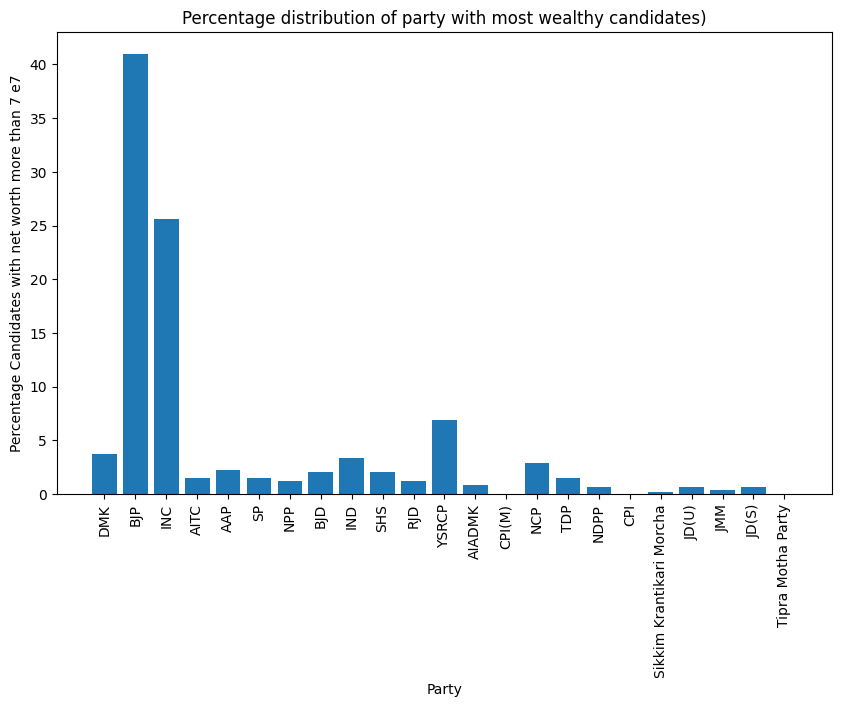

In [176]:
plt.figure(figsize=(10, 6))
plt.bar(xp2, yp2)
plt.xlabel('Party')
plt.ylabel('Percentage Candidates with net worth more than 7 e7')
plt.title('Percentage distribution of party with most wealthy candidates)')
plt.xticks(rotation=90)
plt.show()